# TRABAJO APRENDIZAJE AUTOMÁTICO

Guzmán Muñoz Revuelta

Fernando Caruana del Pino

En esta última parte del trabajo estudiaremos a fondo todos los modelos vistos en clase, y escogeremos el más óptimo en función de su exactitud, precisión, recall y f1-score de los 1 que se obtengan en la matriz de confusión. Los valores 1 eran los fraudes, objetivo buscado en este trabajo. Una vez trabajado con todos los modelos y escogido el mejor, le añadiremos hiperparámetros para intentar mejorar un poco los valores obtenidos. Los modelos realizados son:

Modelo de Árbol

Support Vector Machine (SVM)

RandomForest

Perception Learning Rule

XGBoost

AdaBoost Classifier

GradientBoost Classifier

LightGBM

Además, una vez escogido el modelo óptimo, entraremos en el ámbito de la explicabilidad usando el SHAP. El SHAP (Shapley Additive exPlanations) es un conjunto de herramientas que crean una importancia a cada variable para la predicción de un modelo. De manera más práctica, el modelo se encarga de obtener unos valores SHAP, hace unos clústeres en función de esos valores y luego vuelve a la tabla raw para ver las características de los individuos que ha seleccionado en esos clústeres.

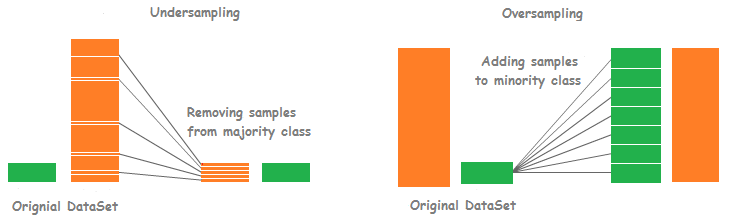

In [15]:
import pickle
import pandas as pd 
import numpy as np
import sklearn
from sklearn.pipeline import Pipeline
from sklearn import metrics
# conda install category_encoders
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics

#from sklearn.metrics import plot_confusion_matrix, roc_curve, roc_auc_score
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier


In [16]:
X_train_scaled=pd.read_csv("../data/X_train_scaled.csv")
X_test_scaled=pd.read_csv("../data/X_test_scaled.csv")
y_train=pd.read_csv("../data/y_train.csv")
y_test=pd.read_csv("../data/y_test.csv")

Recogemos los datos del anterior notebook, en este caso los train y test del modelo, estando las X escaladas.

In [17]:
y_train=y_train.drop('Unnamed: 0', axis=1)
y_test=y_test.drop('Unnamed: 0', axis=1)

## OVERSAMPLING

¿Qué es? El oversampling es otra técnica utilizada para abordar el desbalance de clases en conjuntos de datos. A diferencia del undersampling, que reduce la cantidad de instancias de la clase mayoritaria, el oversampling busca equilibrar las clases aumentando la cantidad de instancias de la clase minoritaria.

El objetivo del oversampling es mejorar el rendimiento del modelo al proporcionarle más información sobre las clases minoritarias, lo que puede ayudar a prevenir el sesgo hacia la clase mayoritaria y permitir que el modelo generalice de manera más efectiva.

In [18]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

## SMOTE
SMOTE (Synthetic Minority Over-sampling Technique) es una técnica de sobre-muestreo utilizada para abordar problemas de desequilibrio de clases. A diferencia del sub-muestreo aleatorio, SMOTE genera puntos de datos sintéticos para lograr un equilibrio igualitario entre la clase minoritaria y mayoritaria. Se selecciona la distancia entre los vecinos más cercanos de la clase minoritaria para crear nuevos puntos sintéticos. SMOTE retiene más información ya que no se eliminan filas, a diferencia del sub-muestreo aleatorio. Sin embargo, SMOTE puede llevar más tiempo de entrenamiento debido a la generación de datos sintéticos.

Cuando se utilizan técnicas como SMOTE o sub-muestreo, es crucial no aplicarlas antes de la validación cruzada. Esto se debe a que pueden influir en el conjunto de validación antes del proceso de validación cruzada, lo que lleva a un sobreajuste. Al hacerlo, existe el riesgo de introducir fuga de datos. En cambio, deberíamos generar puntos de datos sintéticos durante la validación cruzada para evitar afectar al conjunto de validación. De esta manera, los datos sintéticos se crean solo para el conjunto de entrenamiento, asegurando que el conjunto de validación permanezca intacto.

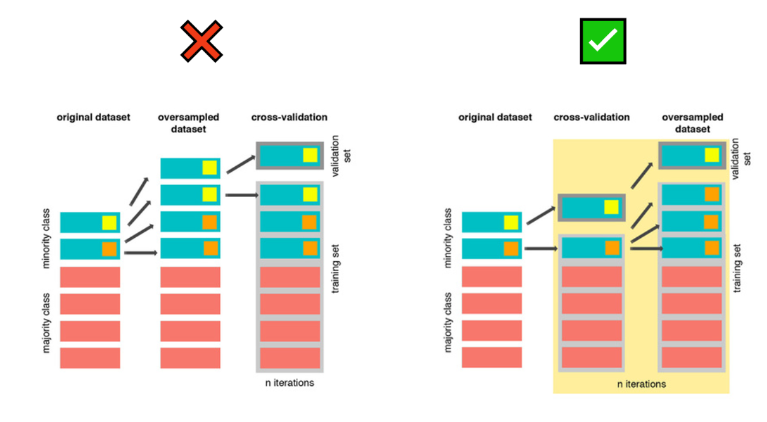

Utilizamos la técnica SMOTE aumentando donde hacemos una técnica de oversampling pero en vez de igualar la cantidad de 0 y 1 de la variable objetivo, en este caso aumentamos en un 80% la cantidad de ceros y un 20% la cantidad de unos para ajustarse más a la realidad de los datos.

In [19]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy=0.2, random_state=42)

In [20]:
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

Ahora dividimos X_train e y_train en train y validación quedándose el test en el 20%, el train_val en un 60% y la validación en otro 20%

In [21]:
from sklearn.model_selection import train_test_split

X_train_val, X_val = train_test_split(X_resampled, test_size=0.2, random_state=42)

In [22]:
from sklearn.model_selection import train_test_split

y_train_val, y_val = train_test_split(y_resampled, test_size=0.2, random_state=42)  

## ESTRATIFICADO

¿Qué es? El muestreo estratificado es otra técnica para resolver el problema del desbalance de clases de conjuntos de datos. A diferencia de las técnicas de oversampling y undersampling, que manipulan directamente la distribución de instancias de las clases, el muestreo estratificado se enfoca en dividir el conjunto de datos en estratos (o subconjuntos) y luego muestrear de manera proporcional desde cada estrato.

In [23]:
import os
folder_path = os.path.join('..', 'models')

# Modelo Base

En esta parte se realizará un modelo como el visto en clase con el dataset Titanic, un modelo muy sencillo donde ninguno de los individuos realiza fraude (lo mismo que en el titanic cuando asumimos que todos morían) que se comparará más adelante con el modelo óptimo elegido.

In [9]:
y_test2=y_test

In [10]:
majority_class = y_test2['fraud_bool'].mode()[0]
y_test2['Predicted_fraud_bool'] = majority_class

In [11]:
y_test= y_test.drop('Predicted_fraud_bool',axis=1)

Precisión del modelo base: 0.98897


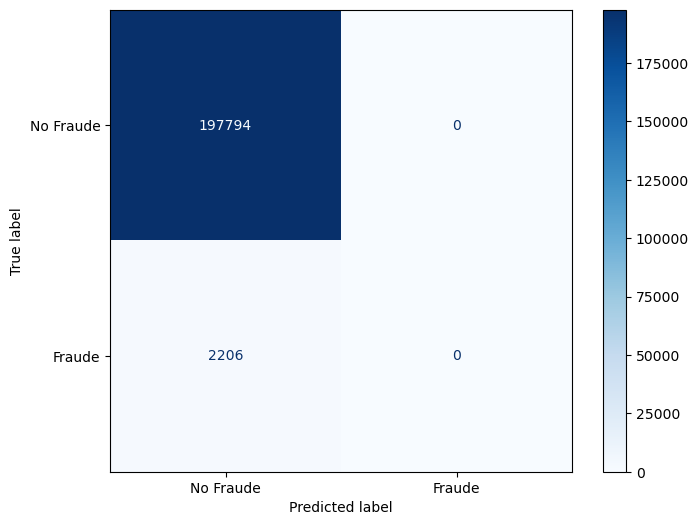

In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
accuracy = accuracy_score(y_test,y_test2['Predicted_fraud_bool'])
print("Precisión del modelo base:", accuracy)
y_real = y_test
y_pred =y_test2['Predicted_fraud_bool']
display_labels = ['No Fraude', 'Fraude']
matriz_confusion = confusion_matrix(y_real, y_pred)

# Crea la visualización de la matriz de confusión
vis = sklearn.metrics.ConfusionMatrixDisplay(matriz_confusion, display_labels=display_labels)

# Muestra el gráfico
fig, ax = plt.subplots(figsize=(8, 6))
vis.plot(ax=ax, cmap='Blues', values_format='d', xticks_rotation='horizontal')
plt.show()


# <font color = 'lightgreen'> GLM 

El GLM (Modelo Linear Generalizado) es una generalización flexible de la regresión lineal ordinaria que permite variables de respuesta que tienen modelos de distribución de errores distintos de una distribución normal. El GLM generaliza la regresión lineal al permitir que el modelo lineal esté relacionado con la variable de respuesta a través de una función de enlace y al permitir que la magnitud de la varianza de cada medición sea una función de su valor predicho. Son una extensión de los modelos lineales tradicionales que permiten la especificación de distribuciones de probabilidad más generales y relaciones no lineales entre las variables dependientes e independientes. En este caso se trabaja con el train:

C:\Users\carua\OneDrive\Documentos\anaconda\envs\EDA\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of the logistic regression model: 0.8821379481048857
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93    158264
           1       0.71      0.49      0.58     31619

    accuracy                           0.88    189883
   macro avg       0.81      0.73      0.76    189883
weighted avg       0.87      0.88      0.87    189883

Matriz de Confusión:


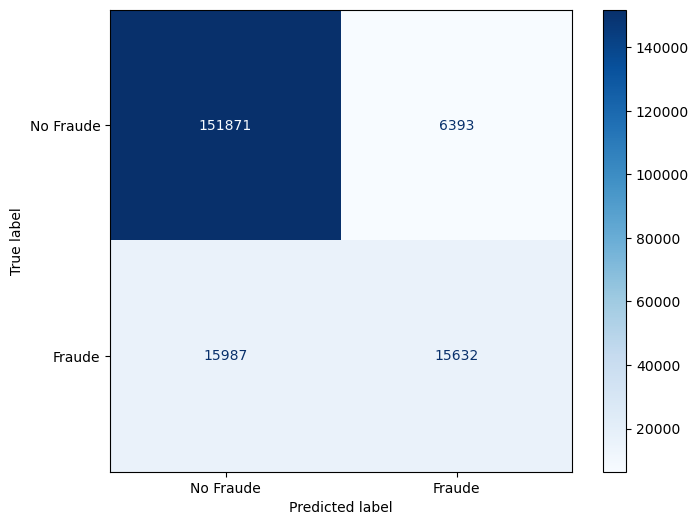

CPU times: total: 14.4 s
Wall time: 6.53 s


In [25]:
%%time
from sklearn.linear_model import LogisticRegression
# Create a logistic regression model
logreg = LogisticRegression()

# Fit the model on the undersampled data
logreg.fit(X_train_val, y_train_val)

# Predict on the test data
y_pred = logreg.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy of the logistic regression model:", accuracy)

print("Reporte de Clasificación:")
print(classification_report(y_val, y_pred))

print("Matriz de Confusión:")
matriz=confusion_matrix(y_val, y_pred)
display_labels = ['No Fraude', 'Fraude']

vis = sklearn.metrics.ConfusionMatrixDisplay(matriz, display_labels=display_labels)
fig, ax = plt.subplots(figsize=(8, 6))
vis.plot(ax=ax, cmap='Blues', values_format='d', xticks_rotation='horizontal')
plt.show()

model_name = 'modelo_GLM_ros.pkl'
pickle_file_path = os.path.join(folder_path, model_name)
with open(pickle_file_path, 'wb') as file:
    pickle.dump(logreg, file)


# <font color = 'lightgreen'> BAYES

El modelo Naive Bayes hace la suposición de que las características son independientes dadas las clases, lo que simplifica la fórmula y los cálculos.El clasificador Naive Bayes se basa en el teorema de Bayes, que se utiliza para calcular las probabilidades condicionales de las clases dados los datos de entrada. A pesar de su simplicidad y la asunción de independencia condicional, los clasificadores Naive Bayes a menudo funcionan sorprendentemente bien en una variedad de problemas del mundo real, especialmente en problemas de clasificación de texto.

Scikit-learn implementa varios clasificadores Naive Bayes.

### Gaussian Naive Bayes (GaussianNB):

En el caso de Gaussian Naive Bayes, se asume que las características siguen una distribución normal (gaussiana). Esto significa que el modelo estima los parámetros de la distribución normal para cada clase y cada característica (media y desviación estándar).

### Multinomial Naive Bayes (MultinomialNB):
Frecuentemente utilizado en clasificación de texto.En el caso de Multinomial Naive Bayes, se asume que las características representan recuentos o frecuencias de ocurrencia de eventos discretos, como recuentos de palabras en documentos. Este modelo estima las probabilidades de ocurrencia de cada palabra para cada clase.

### Complement Naive Bayes:
El Complement Naive Bayes es una variante del clasificador Naive Bayes que está diseñada para abordar el problema del desequilibrio de clases. Mientras que el clasificador Naive Bayes estándar asume independencia condicional entre las características dadas las clases, el Complement Naive Bayes se introdujo para mejorar el rendimiento en conjuntos de datos desequilibrados.La idea detrás del Complement Naive Bayes es que, al considerar la información de todas las demás clases al calcular las probabilidades, se mejora la capacidad del modelo para manejar clases minoritarias. Esto es especialmente útil en situaciones donde hay clases con pocos ejemplos en comparación con las clases mayoritarias.

### Bernoulli Naive Bayes (BernoulliNB):

En el caso de Bernoulli Naive Bayes, se asume que las características son variables binarias, es decir, toman valores de 0 o 1. Este modelo estima las probabilidades de ocurrencia de 0 o 1 para cada característica y cada clase.

### Categorical Naive Bayes:
El clasificador Categorical Naive Bayes es adecuado cuando las características son categóricas y no numéricas, lo que significa que no tiene sentido calcular la media y la desviación estándar como en el caso de Gaussian Naive Bayes. Este clasificador es útil en problemas donde las características son variables categóricas, como en encuestas donde las respuestas son categorías discretas.

C:\Users\carua\OneDrive\Documentos\anaconda\envs\EDA\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of the Gaussian Naive Bayes model: 0.7204752400162205
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.69      0.81    158264
           1       0.36      0.85      0.50     31619

    accuracy                           0.72    189883
   macro avg       0.66      0.77      0.65    189883
weighted avg       0.86      0.72      0.76    189883

Confusion Matrix:


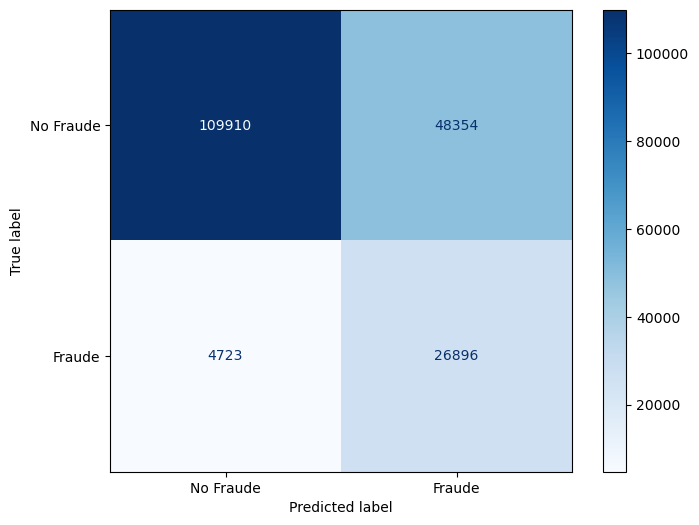

CPU times: total: 2.98 s
Wall time: 3 s


In [32]:
%%time
from sklearn.naive_bayes import GaussianNB

# Create a Gaussian Naive Bayes model
gnb = GaussianNB()

# Fit the model on the undersampled data
gnb.fit(X_resampled, y_resampled)

# Predict on the validation data
y_pred = gnb.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy of the Gaussian Naive Bayes model:", accuracy)

print("Classification Report:")
print(classification_report(y_val, y_pred))

print("Confusion Matrix:")
matriz=confusion_matrix(y_val, y_pred)
display_labels = ['No Fraude', 'Fraude']

vis = sklearn.metrics.ConfusionMatrixDisplay(matriz, display_labels=display_labels)
fig, ax = plt.subplots(figsize=(8, 6))
vis.plot(ax=ax, cmap='Blues', values_format='d', xticks_rotation='horizontal')
plt.show()

model_name = 'modelo_bayes_ros.pkl'
pickle_file_path = os.path.join(folder_path, model_name)
with open(pickle_file_path, 'wb') as file:
    pickle.dump(gnb, file)



# Modelo de Árbol

Un modelo de árbol es un tipo de modelo de aprendizaje automático que se utiliza tanto en problemas de clasificación como en problemas de regresión. La estructura del modelo se asemeja a un árbol con nodos internos y hojas. Cada nodo interno representa una prueba en una característica, cada rama representa el resultado de la prueba, y cada hoja representa la predicción o la clasificación final

In [28]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train_val, y_train_val)

DecisionTreeClassifier()

In [30]:
y_pred = tree_model.predict(X_val)

Exactitud: 0.972951765034258
              precision    recall  f1-score   support

           0       0.99      0.98      0.98    158264
           1       0.91      0.93      0.92     31619

    accuracy                           0.97    189883
   macro avg       0.95      0.96      0.95    189883
weighted avg       0.97      0.97      0.97    189883

Matriz de Confusión:


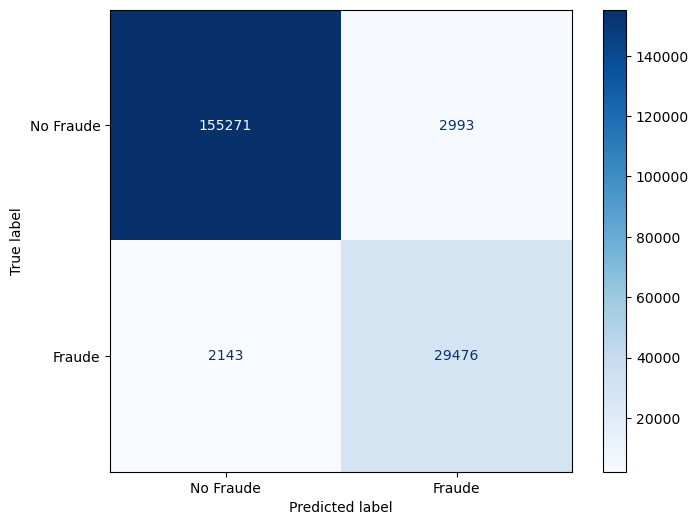

CPU times: total: 812 ms
Wall time: 788 ms


In [31]:
%%time
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
accuracy = accuracy_score(y_val, y_pred)
print("Exactitud:", accuracy)
print(classification_report(y_val, y_pred))
print("Matriz de Confusión:")
matriz=confusion_matrix(y_val, y_pred)
matriz=confusion_matrix(y_val, y_pred)
display_labels = ['No Fraude', 'Fraude']

vis = sklearn.metrics.ConfusionMatrixDisplay(matriz, display_labels=display_labels)
fig, ax = plt.subplots(figsize=(8, 6))
vis.plot(ax=ax, cmap='Blues', values_format='d', xticks_rotation='horizontal')
plt.show()

model_name = 'modelo_arbol_ros.pkl'
pickle_file_path = os.path.join(folder_path, model_name)
with open(pickle_file_path, 'wb') as file:
    pickle.dump(tree_model, file)



# RandomForest

El modelo RandomForest es un algoritmo de aprendizaje automático que construye múltiples árboles de decisión y combina sus predicciones para mejorar la robustez y generalización del modelo. La aleatoriedad en la selección de datos y características reduce el sobreajuste, y la predicción final se determina por votación (clasificación) o promediado (regresión) de los árboles. Es conocido por su rendimiento sólido y versatilidad en tareas de clasificación y regresión.

C:\Users\carua\OneDrive\Documentos\anaconda\envs\EDA\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Exactitud: 0.9910997824976433
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    158264
           1       0.99      0.95      0.97     31619

    accuracy                           0.99    189883
   macro avg       0.99      0.98      0.98    189883
weighted avg       0.99      0.99      0.99    189883

Matriz de Confusión:


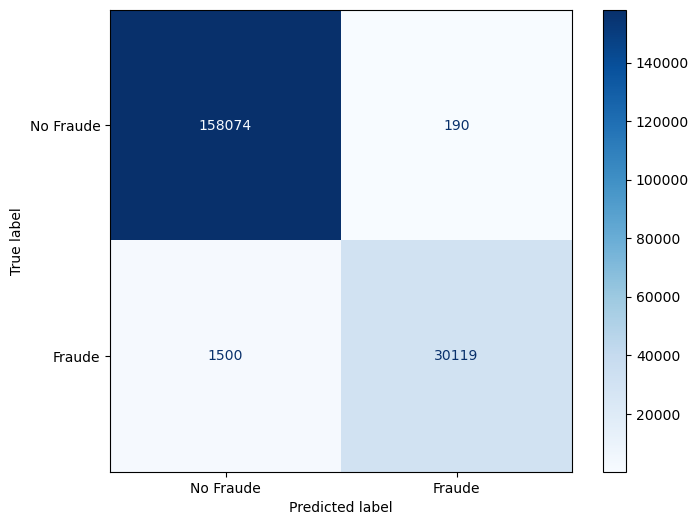

CPU times: total: 13min 47s
Wall time: 14min 3s


In [44]:
%%time
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_val, y_train_val)

y_pred = rf_model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print("Exactitud:", accuracy)

print("Reporte de Clasificación:")
print(classification_report(y_val, y_pred))
print("Matriz de Confusión:")
matriz2=confusion_matrix(y_val, y_pred)
display_labels = ['No Fraude', 'Fraude']
vis = sklearn.metrics.ConfusionMatrixDisplay(matriz2, display_labels=display_labels)
fig, ax = plt.subplots(figsize=(8, 6))
vis.plot(ax=ax, cmap='Blues', values_format='d', xticks_rotation='horizontal')
plt.show()

model_name = 'modelo_randomforest_ros.pkl'
pickle_file_path = os.path.join(folder_path, model_name)
with open(pickle_file_path, 'wb') as file:
    pickle.dump(rf_model, file)

# PERCEPTION LEARNING RULE

El modelo Perception Learning Rule es un algoritmo de aprendizaje para un perceptrón, un tipo simple de red neuronal. Se utiliza para ajustar los pesos de entrada de manera que el perceptrón pueda clasificar correctamente las instancias de entrada. La regla de aprendizaje actualiza los pesos basándose en la diferencia entre la predicción del perceptrón y la clase real, multiplicada por las características de entrada.

C:\Users\carua\OneDrive\Documentos\anaconda\envs\EDA\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Exactitud: 0.8053064255357246
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89    158264
           1       0.33      0.17      0.22     31619

    accuracy                           0.81    189883
   macro avg       0.59      0.55      0.56    189883
weighted avg       0.76      0.81      0.78    189883

Matriz de Confusión:


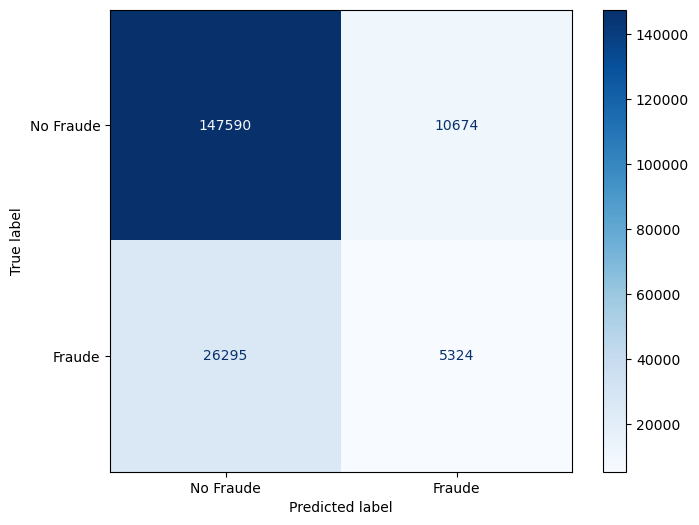

CPU times: total: 5.2 s
Wall time: 4.71 s


In [33]:
%%time
from sklearn.linear_model import Perceptron
# Crear un objeto Perceptrón
perceptron_model = Perceptron(random_state=42)

# Entrenar el modelo
perceptron_model.fit(X_train_val, y_train_val)

# Realizar predicciones en el conjunto de prueba
y_pred = perceptron_model.predict(X_val)

# Evaluar el rendimiento del modelo
accuracy = accuracy_score(y_val, y_pred)
print("Exactitud:", accuracy)

print("Reporte de Clasificación:")
print(classification_report(y_val, y_pred))

print("Matriz de Confusión:")
matriz3=(confusion_matrix(y_val, y_pred))
display_labels = ['No Fraude', 'Fraude']

# Crea la visualización de la matriz de confusión
vis = sklearn.metrics.ConfusionMatrixDisplay(matriz3, display_labels=display_labels)

# Muestra el gráfico
fig, ax = plt.subplots(figsize=(8, 6))
vis.plot(ax=ax, cmap='Blues', values_format='d', xticks_rotation='horizontal')
plt.show()
model_name = 'perception_model_ros.pkl'
pickle_file_path = os.path.join(folder_path, model_name)
with open(pickle_file_path, 'wb') as file:
    pickle.dump(perceptron_model, file)


# XGBOOST

El XGBoost es un algoritmo de aprendizaje automático que se destaca por su eficacia y velocidad. Se utiliza para problemas de clasificación y regresión. XGBoost significa "Extreme Gradient Boosting" y es una implementación optimizada de algoritmos de boosting. Combina múltiples modelos débiles (generalmente árboles de decisión) para mejorar la precisión general del modelo, minimizando el error de predicción.

Exactitud: 0.9892512757856153
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    158264
           1       1.00      0.94      0.97     31619

    accuracy                           0.99    189883
   macro avg       0.99      0.97      0.98    189883
weighted avg       0.99      0.99      0.99    189883

Matriz de Confusión:


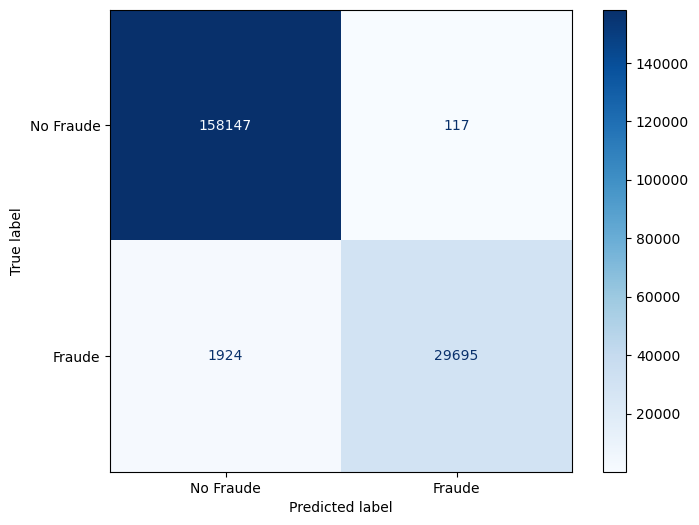

CPU times: total: 1min 30s
Wall time: 14.8 s


In [39]:
%%time
import xgboost as xgb
# Crear el clasificador XGBoost sin parámetros específicos
xgb_model = xgb.XGBClassifier()

# Entrenar el modelo
xgb_model.fit(X_train_val, y_train_val)

# Realizar predicciones en el conjunto de prueba
y_pred = xgb_model.predict(X_val)

# Evaluar el rendimiento del modelo
accuracy = accuracy_score(y_val, y_pred)
print("Exactitud:", accuracy)

print("Reporte de Clasificación:")
print(classification_report(y_val, y_pred))

print("Matriz de Confusión:")
matriz4=(confusion_matrix(y_val, y_pred))
# Supongamos que 'fraude' es la clase positiva (1) y 'no fraude' es la clase negativa (0)
display_labels = ['No Fraude', 'Fraude']
vis = sklearn.metrics.ConfusionMatrixDisplay(matriz4, display_labels=display_labels)
fig, ax = plt.subplots(figsize=(8, 6))
vis.plot(ax=ax, cmap='Blues', values_format='d', xticks_rotation='horizontal')
plt.show()

model_name = 'xgb_model_ros.pkl'
pickle_file_path = os.path.join(folder_path, model_name)
with open(pickle_file_path, 'wb') as file:
    pickle.dump(xgb_model, file)

# AdaBoostClassifier

El modelo AdaBoost es un algoritmo que combina varios modelos débiles para formar un modelo fuerte. Se enfoca en las instancias mal clasificadas, asignándoles más peso en cada iteración. De esta manera, sucesivos modelos se centran en corregir los errores del modelo anterior, mejorando la precisión global.

C:\Users\carua\OneDrive\Documentos\anaconda\envs\EDA\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Exactitud: 0.9460983869014077
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97    158264
           1       0.90      0.77      0.83     31619

    accuracy                           0.95    189883
   macro avg       0.93      0.87      0.90    189883
weighted avg       0.94      0.95      0.94    189883

Matriz de Confusión:


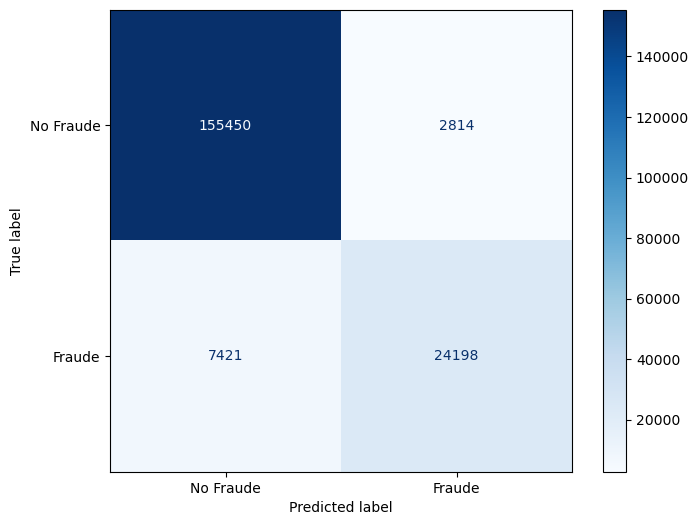

CPU times: total: 4min 51s
Wall time: 4min 54s


In [40]:
%%time
from sklearn.ensemble import AdaBoostClassifier

base_classifier = DecisionTreeClassifier(max_depth=1)

# Crear el clasificador AdaBoost
adaboost_model = AdaBoostClassifier(base_classifier, n_estimators=50, random_state=42)

# Entrenar el modelo
adaboost_model.fit(X_train_val, y_train_val)

# Realizar predicciones en el conjunto de prueba
y_pred = adaboost_model.predict(X_val)

# Evaluar el rendimiento del modelo
accuracy = accuracy_score(y_val, y_pred)
print("Exactitud:", accuracy)

print("Reporte de Clasificación:")
print(classification_report(y_val, y_pred))

print("Matriz de Confusión:")
matriz5=(confusion_matrix(y_val, y_pred))
# Supongamos que 'fraude' es la clase positiva (1) y 'no fraude' es la clase negativa (0)
display_labels = ['No Fraude', 'Fraude']

# Crea la visualización de la matriz de confusión
vis = sklearn.metrics.ConfusionMatrixDisplay(matriz5, display_labels=display_labels)

# Muestra el gráfico
fig, ax = plt.subplots(figsize=(8, 6))
vis.plot(ax=ax, cmap='Blues', values_format='d', xticks_rotation='horizontal')
plt.show()

model_name = 'ada_model_ros.pkl'
pickle_file_path = os.path.join(folder_path, model_name)
with open(pickle_file_path, 'wb') as file:
    pickle.dump(adaboost_model, file)

# GradientBoostClassifier

C:\Users\carua\OneDrive\Documentos\anaconda\envs\EDA\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Exactitud: 0.9701763717657715
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    158264
           1       0.98      0.84      0.90     31619

    accuracy                           0.97    189883
   macro avg       0.97      0.92      0.94    189883
weighted avg       0.97      0.97      0.97    189883

Matriz de Confusión:


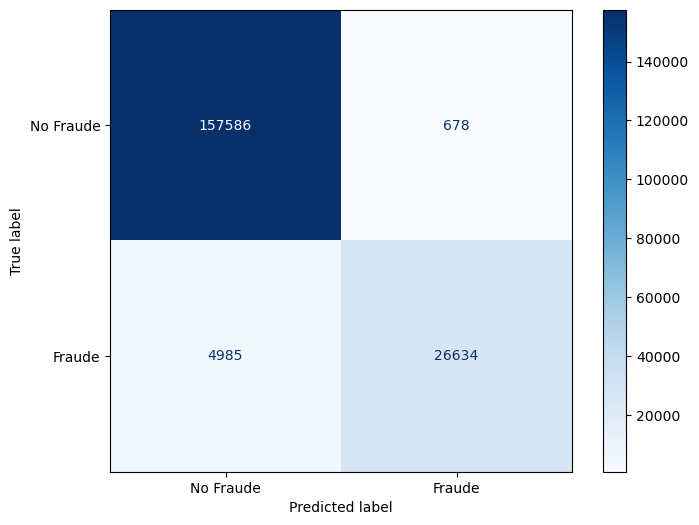

CPU times: total: 19min 17s
Wall time: 19min 21s


In [45]:
%%time
from sklearn.ensemble import GradientBoostingClassifier

# Crear el clasificador GradientBoosting
gradientboost_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Entrenar el modelo
gradientboost_model.fit(X_train_val, y_train_val)

# Realizar predicciones en el conjunto de prueba
y_pred = gradientboost_model.predict(X_val)

# Evaluar el rendimiento del modelo
accuracy = accuracy_score(y_val, y_pred)
print("Exactitud:", accuracy)

print("Reporte de Clasificación:")
print(classification_report(y_val, y_pred))

print("Matriz de Confusión:")
matriz6=(confusion_matrix(y_val, y_pred))
# Supongamos que 'fraude' es la clase positiva (1) y 'no fraude' es la clase negativa (0)
display_labels = ['No Fraude', 'Fraude']

# Crea la visualización de la matriz de confusión
vis = sklearn.metrics.ConfusionMatrixDisplay(matriz6, display_labels=display_labels)

# Muestra el gráfico
fig, ax = plt.subplots(figsize=(8, 6))
vis.plot(ax=ax, cmap='Blues', values_format='d', xticks_rotation='horizontal')
plt.show()

model_name = 'gradientboost_model_ros.pkl'
pickle_file_path = os.path.join(folder_path, model_name)
with open(pickle_file_path, 'wb') as file:
    pickle.dump(gradientboost_model, file)

# LightGBM

El LightGBM es una biblioteca eficiente de gradient boosting diseñada para entrenar modelos de aprendizaje automático de forma rápida y escalable, especialmente útil para conjuntos de datos grandes.

C:\Users\carua\OneDrive\Documentos\anaconda\envs\EDA\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\carua\OneDrive\Documentos\anaconda\envs\EDA\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 126616, number of negative: 632913
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.124727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9242
[LightGBM] [Info] Number of data points in the train set: 759529, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166703 -> initscore=-1.609174
[LightGBM] [Info] Start training from score -1.609174
Accuracy: 0.9694654076457608
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    158264
           1       0.97      0.84      0.90     31619

    accuracy                           0.97    189883
   macro avg       0.97      0.92      0.94    189883
weighted avg       0.97      0.97      0.97    189883

Matriz de Confusión:


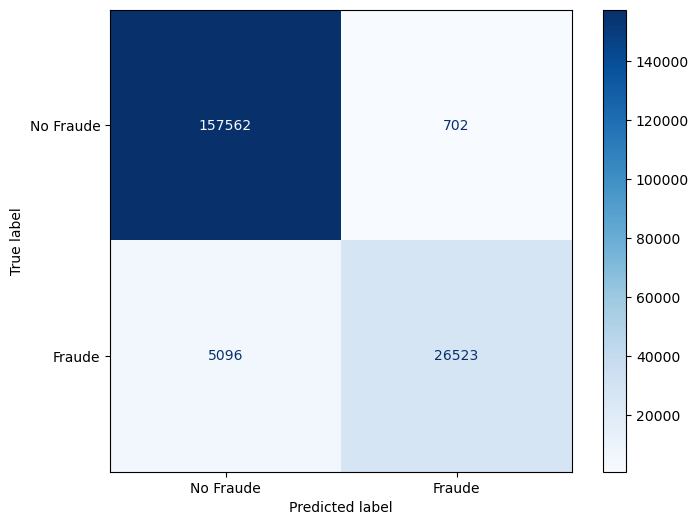

CPU times: total: 25.6 s
Wall time: 7.85 s


In [42]:
%%time
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=3,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary',
    random_state=42
)

# Entrena el modelo
lgb_model.fit(X_train_val, y_train_val)

# Realiza predicciones en el conjunto de prueba
y_pred = lgb_model.predict(X_val)

# Evalúa la precisión del modelo
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)
print("Reporte de Clasificación:")
print(classification_report(y_val, y_pred))

print("Matriz de Confusión:")
matriz7=confusion_matrix(y_val, y_pred)
with open('modelo_lgb_ros.pkl', 'wb') as file:
    pickle.dump(lgb_model, file)
    
# Supongamos que 'fraude' es la clase positiva (1) y 'no fraude' es la clase negativa (0)
display_labels = ['No Fraude', 'Fraude']

# Crea la visualización de la matriz de confusión
vis = sklearn.metrics.ConfusionMatrixDisplay(matriz7, display_labels=display_labels)

# Muestra el gráfico
fig, ax = plt.subplots(figsize=(8, 6))
vis.plot(ax=ax, cmap='Blues', values_format='d', xticks_rotation='horizontal')
plt.show()

model_name = 'LightGBM_model_ros.pkl'
pickle_file_path = os.path.join(folder_path, model_name)
with open(pickle_file_path, 'wb') as file:
    pickle.dump(lgb_model, file)

# MEJOR MODELO XGBOOST

Accuracy en el conjunto de prueba: 0.988865
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    197794
           1       0.46      0.05      0.09      2206

    accuracy                           0.99    200000
   macro avg       0.72      0.53      0.54    200000
weighted avg       0.98      0.99      0.98    200000

Matriz de Confusión:
[[197658    136]
 [  2091    115]]


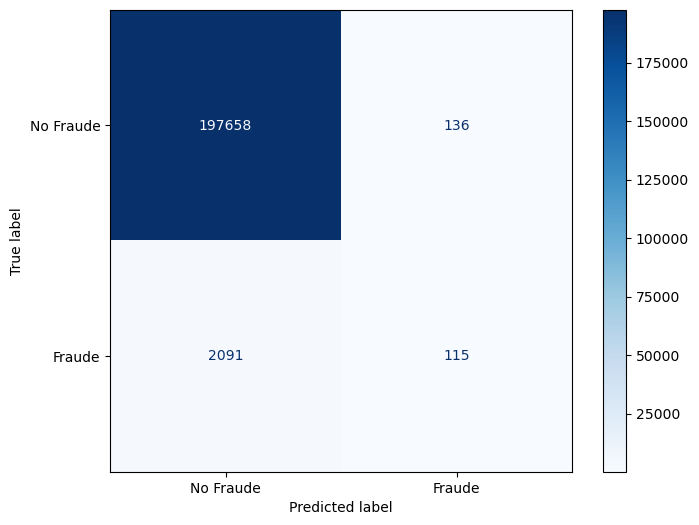

CPU times: total: 58.5 s
Wall time: 16.1 s


In [43]:
%%time
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_resampled, y_resampled)

# Realiza predicciones en el conjunto de prueba
y_pred = xgb_model.predict(X_test_scaled)

# Evalúa la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy en el conjunto de prueba:", accuracy)
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))
print("Matriz de Confusión:")
matriz8=(confusion_matrix(y_test, y_pred))
print(matriz8)

# Supongamos que 'fraude' es la clase positiva (1) y 'no fraude' es la clase negativa (0)
display_labels = ['No Fraude', 'Fraude']

# Crea la visualización de la matriz de confusión
vis = sklearn.metrics.ConfusionMatrixDisplay(matriz8, display_labels=display_labels)

# Muestra el gráfico
fig, ax = plt.subplots(figsize=(8, 6))
vis.plot(ax=ax, cmap='Blues', values_format='d', xticks_rotation='horizontal')
plt.show()

model_name = 'mejor_modelo_ros.pkl'
pickle_file_path = os.path.join(folder_path, model_name)
with open(pickle_file_path, 'wb') as file:
    pickle.dump(xgb_model, file)

# Conclusiones

En este caso observamos que el modelo de XGBOOST empeora a la hora de entrenarlo comparado con la validación,además al ser tan grande la cantidad de datos a entrenar, impide al modelo añadirle hiperparámetros.Al tener un f1-score tan bajo decidimos probar los modelos con el método de undersampling y efectivamente en el notebook 05.1_rus se puede observar que el mejor modelo con el método undersampling tiene mucho mejor resultado que este, por lo tanto, decidimos descartar el método oversampling para el entrenamiento del modelo.